In [2]:
import numpy as np
import scipy as sp
import scipy.stats as spst
import matplotlib.pyplot as plt

In [44]:
def model(x, sign=1):
    f = 3 + 2*x
    y = f + spst.norm(0,sign).rvs(size=x.shape[0])
    return y


# training data
X_train = spst.uniform(-5,10).rvs(size=50)
y_train = model(X_train)
# prediction (test) data
X_test = spst.uniform(-5,10).rvs(size=10)
y_test = model(X_test)

In [45]:
def predGLR(X_pred, X_train, y_train, Sign, Sigp, alph=0.05):
    if len(X_train.shape)==1:
        X_train = X_train.reshape(-1,1)
        X_pred = X_pred.reshape(-1,1)
    y_train = y_train.reshape(-1,1)
    X_train = np.concatenate((np.ones((X_train.shape[0],1)), X_train), axis=1)
    X_pred = np.concatenate((np.ones((X_pred.shape[0],1)), X_pred), axis=1)
    
    A = X_train.T @ np.linalg.inv(Sign) @ X_train + np.linalg.inv(Sigp)
    Beta = np.linalg.inv(A) @ X_train.T @ np.linalg.inv(Sign) @ y_train
    
    y_pred_ave = X_pred @ Beta
    y_pred_cov = np.diag(X_pred @ np.linalg.inv(A) @ X_pred.T).reshape(-1,1)
    y_pred_inf, y_pred_sup = spst.norm.interval(1-alph/2, y_pred_ave, np.sqrt(y_pred_cov.reshape(len(y_pred_cov),1)))
    
    return [y_pred_ave, y_pred_cov, y_pred_inf, y_pred_sup]

In [69]:
sign = 1
Sign = np.diag(np.repeat(sign**2,X_train.shape[0]))
Sigp = np.diag(np.repeat(1e10,2))
alph = 0.3
X_pred = np.linspace(-5,5,100)
y_pred_ave, y_pred_cov, y_pred_inf, y_pred_sup = predGLR(X_pred,X_train,y_train,Sign,Sigp,alph)

array([[1.e+10, 0.e+00],
       [0.e+00, 1.e+10]])

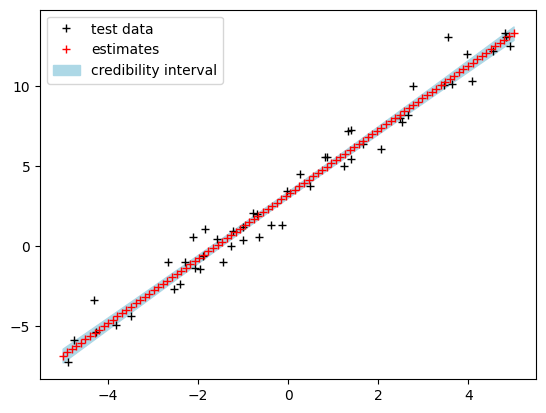

In [66]:
fig, ax = plt.subplots()
ax.plot(X_train, y_train, 'k+', label='test data')
ax.plot(X_pred, y_pred_ave, 'r+', label='estimates')
ax.fill_between(X_pred, y_pred_inf.reshape(-1), y_pred_sup.reshape(-1),color='lightblue', label='credibility interval')
ax.legend()

In [70]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import DotProduct as DP, WhiteKernel as WK

In [72]:
def model(x, sign=1):
    f = x * np.cos(x)
    y = f + spst.norm(0,sign).rvs(size=x.shape)
    return  y

Xtr = spst.uniform(0,10).rvs(size=20)
ytr = model(Xtr, 0)

Xpr = spst.uniform(0,10).rvs(size=20)
ypr = model(Xpr, 0)

Xpl = np.linspace(0,10,1000)

Xtr = Xtr.reshape(-1,1)
Xpr = Xpr.reshape(-1,1)
Xpl = Xpl.reshape(-1,1)

D:\Programming\Conda_envs\ML\Lib\site-packages\sklearn\gaussian_process\_gpr.py:479: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(


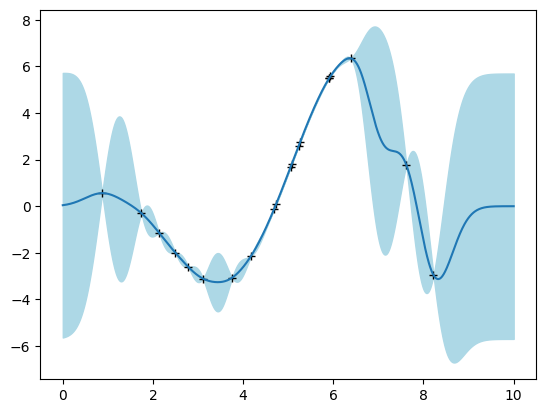

In [114]:
kern = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
GP_0 = GPR(kernel=kern, alpha=0, n_restarts_optimizer=10)
GP_0.fit(Xtr, ytr)
ypl_ave, ypl_std = GP_0.predict(Xpl, return_std=True)

fig, ax = plt.subplots()
ax.plot(Xtr, ytr, 'k+')
ax.plot(Xpl, ypl_ave)
ax.fill_between(x=Xpl.reshape(-1),y1=ypl_ave+spst.norm.ppf(0.025)*ypl_std,y2=ypl_ave+spst.norm.ppf(0.975)*ypl_std, color='lightblue', interpolate=True)

D:\Programming\Conda_envs\ML\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


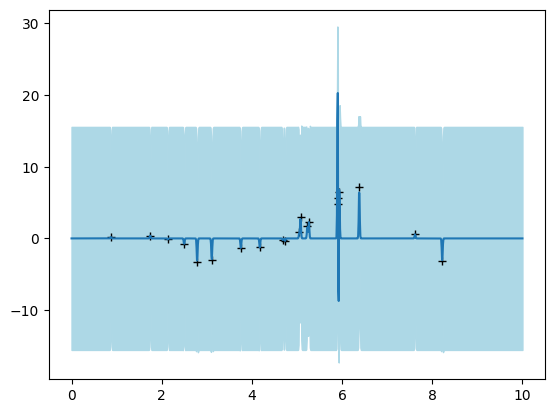

In [119]:
ytr_noi = model(Xtr.ravel(), 1)
# model instantiation and training
GP_1 = GPR(kernel=kern, alpha=0, n_restarts_optimizer=10)
GP_1.fit(Xtr, ytr_noi)
# predictions for the plot instances
ypl_ave_1, ypl_std_1 = GP_1.predict(Xpl, return_std=True)
# display
fig, ax = plt.subplots()
ax.plot(Xtr, ytr_noi, 'k+')
ax.plot(Xpl, ypl_ave_1)
ax.fill_between(x=Xpl.reshape(-1),y1=ypl_ave_1+spst.norm.ppf(0.025)*ypl_std_1,y2=ypl_ave_1+spst.norm.ppf(0.975)*ypl_std_1,color='lightblue', interpolate=True)

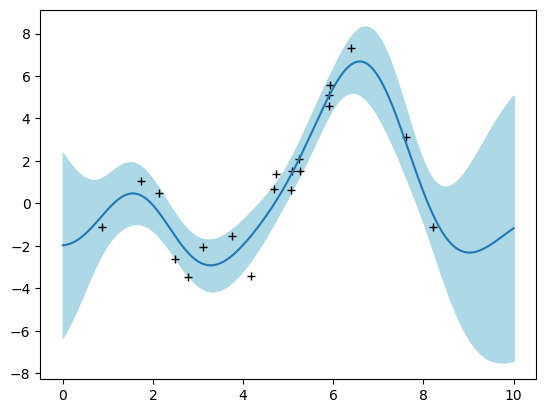

In [100]:
# model instantiation and training
GP_2 = GPR(kernel=kern, alpha=1, n_restarts_optimizer=10)
GP_2.fit(Xtr, ytr_noi)
# predictions for the plot instances
ypl_ave_2, ypl_std_2 = GP_2.predict(Xpl, return_std=True)
# display
fig, ax = plt.subplots()
ax.plot(Xtr, ytr_noi, 'k+')
ax.plot(Xpl, ypl_ave_2)
ax.fill_between(x=Xpl.reshape(-1),y1=ypl_ave_2+spst.norm.ppf(0.025)*ypl_std_2,y2=ypl_ave_2+spst.norm.ppf(0.975)*ypl_std_2,color='lightblue', interpolate=True)